In [1]:
import numpy as np
import torch,torchvision
import matplotlib.pyplot as plt
%matplotlib inline

# Homework 3

Homework 3 will cover materials from chapter 5 (CNNs), 6 (CNNs for classification), and 7 (CNN for segmentation).

There is lots of exposition in this homework assignment.  All the problems that need to be solved are labeled with the the title "Problem".

In homework 3, 90% of your grade will be based on the quality and accuracy of the work you do in this notebook.  10% of your grade will be based on how well your CNNs perform relative to the other students in the class.

## Part 1, data augmentation

### 1.1 Our dataset

We will use the dermaMNIST dataset for this problem and the following one.


In [2]:
from medmnist import DermaMNIST
dataset_train = DermaMNIST(split='train',download=True,transform=torchvision.transforms.ToTensor())
dataset_val = DermaMNIST(split='val',download=True,transform=torchvision.transforms.ToTensor())
dataset_test = DermaMNIST(split='test',download=True,transform=torchvision.transforms.ToTensor())

Using downloaded and verified file: /Users/rachelzhang/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/rachelzhang/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/rachelzhang/.medmnist/dermamnist.npz


Text(0.5, 1.0, 'label [5]')

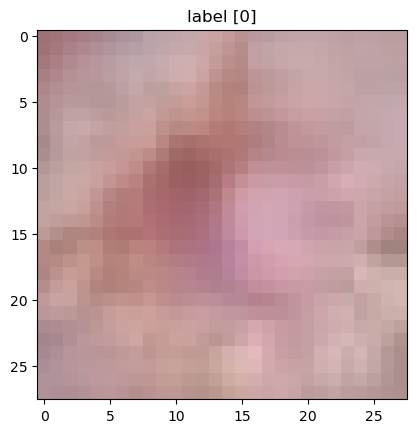

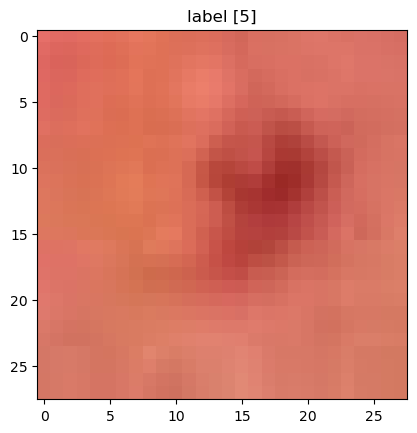

In [3]:
I,l = dataset_train[0]
fig,ax = plt.subplots()
ax.imshow(I.permute(1,2,0))
ax.set_title(f'label {l}')

I,l = dataset_train[1]
fig,ax = plt.subplots()
ax.imshow(I.permute(1,2,0))
ax.set_title(f'label {l}')

### 1.2 a dataset randomizer

Below we provide some code to apply random transformations to our images or labels, and visualize some examples.

We show 5 different label-preserving transformations of the same image.

Note that there are two empty sections that need to be filled in, which are the next two problems.

In [4]:
def interpn(x,I,Xs,**kwargs):
    ''' A utility function based around torch's grid sample function
    but with interface the same as numpy's interpn'''
    # scale sample points to -1 to 1
    x0 = torch.stack([x[0][0],x[1][0]])
    x1 = torch.stack([x[0][-1],x[1][-1]])
    Xs = Xs - x0
    Xs = Xs / (x1 - x0)
    Xs = Xs*2-1
    
    # add and remove a batch dimension if necessary
    if I.ndim == 3:        
        Is = torch.nn.functional.grid_sample(I[None],Xs[None].flip(-1),align_corners=True,**kwargs)[0]
    else:
        Is = torch.nn.functional.grid_sample(I,Xs.flip(-1),align_corners=True,**kwargs)
    return Is

In [5]:
class RandomizedDataset(torch.utils.data.Dataset):
    ''' A class to apply randomizations to your dataset'''
    def __init__(self,dataset,
                 random_rotate=False,
                 random_reflect=False, 
                 random_affine=False,
                 random_deformation=False,
                 random_window_level=False,
                 random_gamma=False,
                 random_noise=False,
                ):
        # set the dataset to a member variable
        self.dataset = dataset
        
        
        
        # set the options to apply randomizations to member variables
        self.random_rotate = random_rotate
        self.random_reflect = random_reflect
        self.random_affine = random_affine
        self.random_deformation = random_deformation
        self.random_window_level = random_window_level
        self.random_gamma = random_gamma
        self.random_noise = random_noise
        
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,i):
        I,l = self.dataset[i]
        # check if the labels are segmentation labels
        # if they are, we will have to apply the same transformations
        # to the labels and the images
        if l.ndim == 1:
            l_is_image = False
        else:
            l_is_image = True
        
        # apply geometric transformations
        # note that we will need to apply the same transform to the image and segmentation
        if self.random_rotate:
            nrot = np.random.randint(4)
            I = torch.rot90(I,nrot,dims=(-1,-2))
            if l_is_image:
                l = torch.rot90(l,nrot,dims=(-1,-2))
        
        if self.random_reflect:
            if np.random.rand()>0.5:
                I = torch.flip(I,dims=(-1,-2))
                if l_is_image:
                    l = torch.flip(l,dims=(-1,-2))
        # get zero centered pixel locations
        x0 = torch.arange(I.shape[-2]) - (I.shape[-2]-1)/2
        x1 = torch.arange(I.shape[-1]) - (I.shape[-1]-1)/2
        X = torch.stack(torch.meshgrid(x0,x1,indexing='ij'),-1)        
        if self.random_affine:
            
            # a random matrix is added to identity for the linear part
            L = torch.eye(2) + torch.randn(2,2)*0.1
            # a random translation with standard deviation of 3 pixels is added to the tanslation
            T = torch.randn(2,1)*3
            # concatenate them
            A = torch.concatenate((L,T),-1)
            A = torch.concatenate((A,torch.tensor([[0.0,0.0,1.0]])),-2)
            Ai = torch.linalg.inv(A)
            # get sample points
            Xs = (Ai[:2,:2]@X[...,None])[...,0] + Ai[:2,-1]
            I = interpn([x0,x1],I,Xs,padding_mode='border')
            if l_is_image:                
                # note we use 'nearest neighbor' interpolation for labels
                l = interpn([x0,x1],l,Xs,mode='nearest',padding_mode='border')
        if self.random_deformation:
            # YOUR WORK HERE
            # 
            # 1. 
            # create 2 28x28 torch tensors which will represent the row and col components of your displacement fields 
            # p0 = torch.randn(28,28)
            p0 = torch.randn(I.shape[-2], I.shape[-1])
            p1 = torch.randn(I.shape[-2], I.shape[-1])
            
            # 2. 
            # multiply them by whatever standard deviation you choose, this will relate to the magnitude of displacement
            std = 3.0
            p0 = p0*std
            p1 = p1*std
            
            # 3. 
            # blur it with a gaussian kernel of whatever width you choose
            # I suggest using the function:  torchvision.transforms.functional.gaussian_blur            
            # but there are other choices we have covered in class        
            # if you use this choice you will have to add a leading dimension to the input, and remove it from the output
            # example of adding and removing a leading dimension:
            # * blurred_image = blur( my_image[None])[0]
            blurred_p0 = torchvision.transforms.functional.gaussian_blur(p0[None], kernel_size = 7)[0]
            blurred_p1 = torchvision.transforms.functional.gaussian_blur(p1[None], kernel_size = 7)[0]
            
            # 4. 
            # stack p0 and p1 into a 28x28x2 array and            
            # interpolate your images at X - your_random_displacement_field
            # Xs = X - torch.stack((p0,p1))
            Xs = X - torch.stack((blurred_p0, blurred_p1), -1)
    
            I = interpn([x0,x1], I, Xs, padding_mode = 'border')
            if l_is_image:                
                l = interpn([x0,x1],l,Xs,mode='nearest',padding_mode='border')
            
            # see the above affine transform for any help with interpolation
            # make sure the std and kernel size you choose lead to realistic images
            pass
                
        
        # apply pixel intsenity transforations
        # these will be applied only to the image
        # and not to the labels
        if self.random_window_level:
            # YOUR WORK HERE!
            # choose a vmin randomly between 0 and 0.25
            # choose a vmax randomly between 0.75 and 1
            # rescale the image so that vmin maps to 0, and vmax maps to 1
            # clip any pixels less than 0 to the value 0
            # clip any pixels greater than 1 to the value 1
            vmin = np.random.rand()*0.25
            vmax = (np.random.rand()*0.25 + 0.75)
            I = (I - vmin)/(vmax - vmin)
            torch.clip(I, min = 0, max = 1)
            
            pass
            
        if self.random_gamma:            
            gamma_ = (np.random.rand()*2-1) # between -1 and 1
            gamma = 2.0**gamma_ # between 0.5 and 2.0
            I = I**gamma
            
        if self.random_noise:
            frac = 0.05
            I = I*(1-frac) + torch.rand(*I.shape)*frac
        return I,l

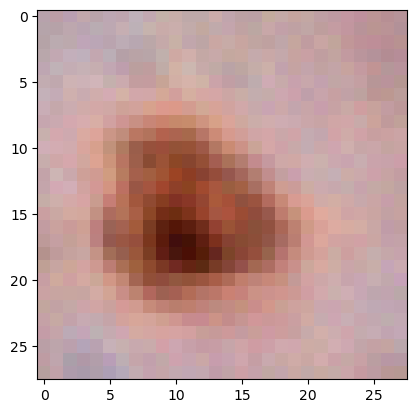

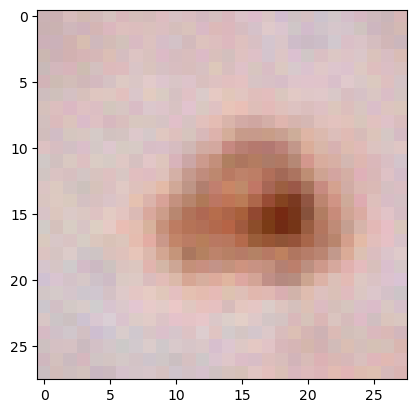

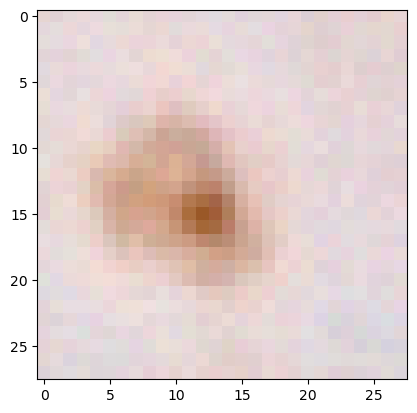

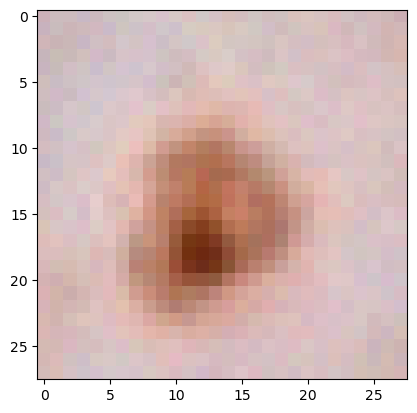

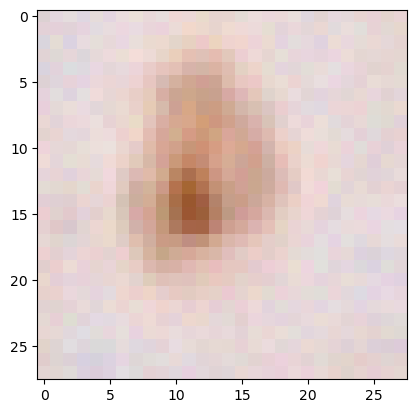

In [6]:
dataset_train_randomized = RandomizedDataset(
    dataset_train,
    random_rotate=True,
    random_reflect=True,    
    random_affine=True,        
    random_noise=True,
    random_gamma=True,    
)
for i in range(5):
    I,l = dataset_train_randomized[4]
    fig,ax = plt.subplots()
    ax.imshow(I.permute(1,2,0))

### Problem 1.3 

Complete the code in the random_window_level section.  Show 5 different random transformations of the same image using the code below.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22238164..0.95996046].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012075751..1.0032663].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27870196..0.9880515].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16510065..1.1809427].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09236858..1.1220969].


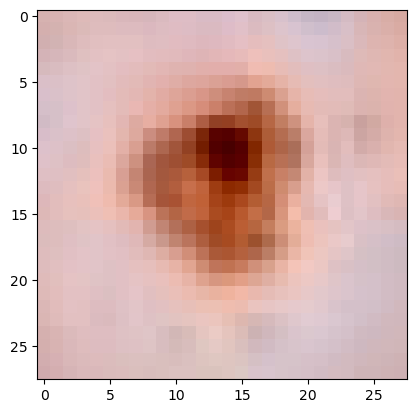

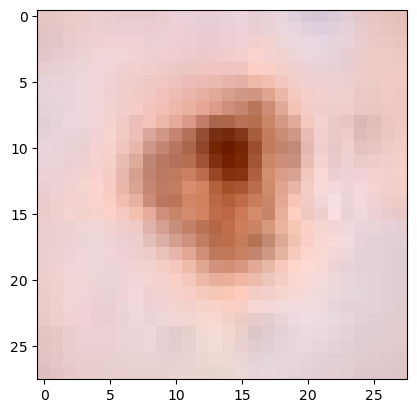

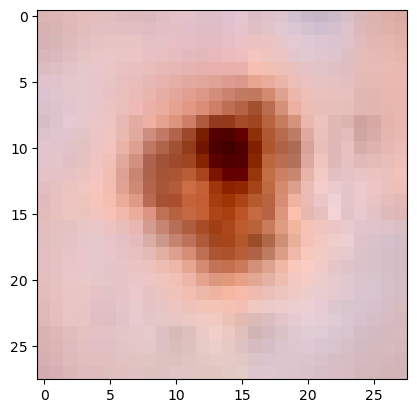

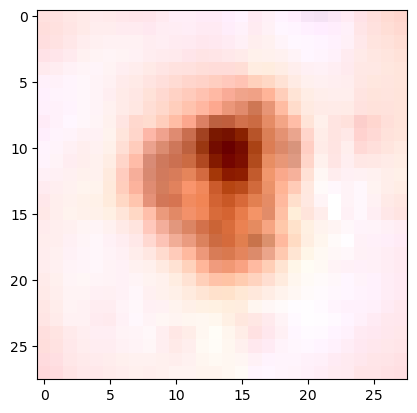

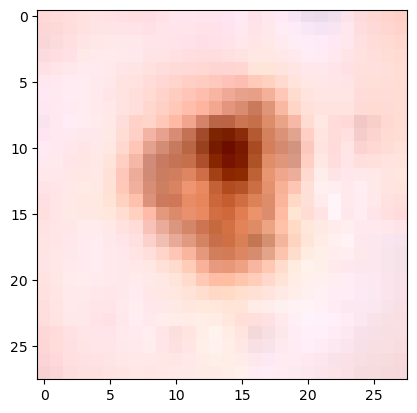

In [7]:
dataset_train_randomized = RandomizedDataset(
    dataset_train,
    random_window_level=True, 
)
for i in range(5):
    I,l = dataset_train_randomized[4]
    fig,ax = plt.subplots()
    ax.imshow(I.permute(1,2,0))

### Problem 1.4

Complete the code in the random deformation section. Show 5 different random transformations of the same image using the code below.

[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


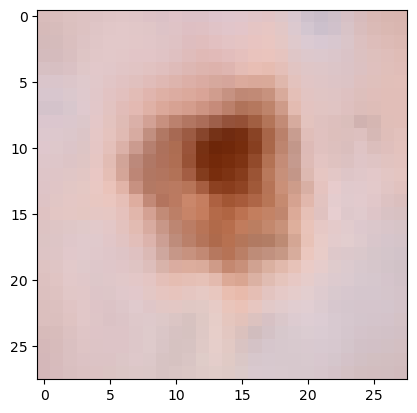

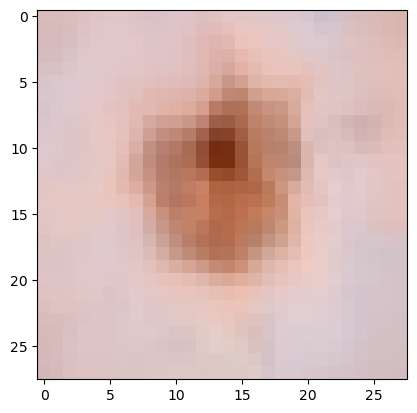

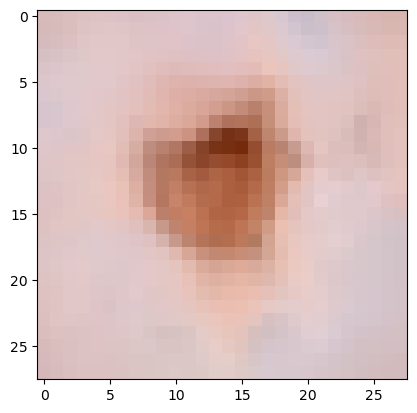

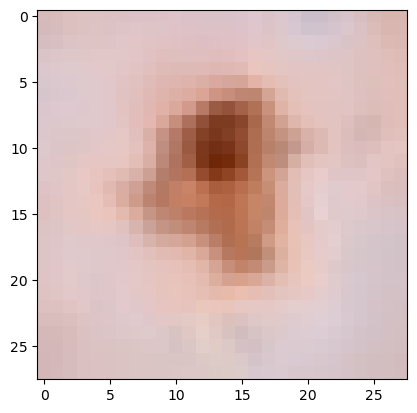

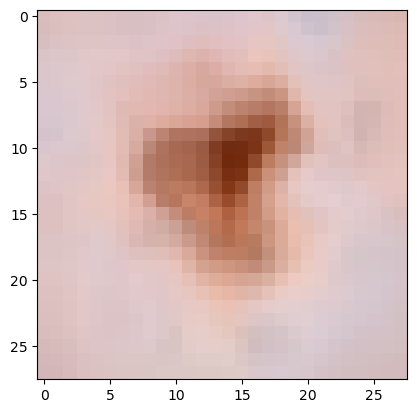

In [8]:
dataset_train_randomized = RandomizedDataset(
    dataset_train,
    random_deformation=True, 
)
for i in range(5):
    I,l = dataset_train_randomized[4]
    fig,ax = plt.subplots()
    ax.imshow(I.permute(1,2,0))

## Part 2, image classification

### Problem 2.1

Design at least two CNNs for classifying the DermaMNIST dataset.

You can choose any design you want, but at least one of the models should not be a copy of what we showed in class.

You may choose to vary the depth or width of the network, the type of data augmentation, any regularization, the loss function, the optimizer, etc.

Train them on the training set (for however long you want), and test their accuracy on the validation set.

Choose the best performing model on the validation set, and report its accuracy on the test set.

I will rerun your notebook, and evaluate perforance in terms of accuracy on a random subset of the test set.  The random subset will be the same for all students.  5% of your grade (out of 100%) on this assignment will be based on your accuracy relative to the other students.  The student with the highest accuracy will recieve 5%. The student with the lowest accuracy will recieve 0%.  The others will vary linearly between these extremes.

In [9]:
# loading datasets
dataloader = torch.utils.data.DataLoader(dataset_train,batch_size=8,num_workers=8)
dataloader_test = torch.utils.data.DataLoader(dataset_test,batch_size=8,num_workers=8)
dataloader_val = torch.utils.data.DataLoader(dataset_val,batch_size=8,num_workers=8)

In [25]:
# CNN 1, simple model with 4 convolution layers and using cross entropy loss (example from class)
class Model1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        channels0 = 8
        kernel_size = 3
        stride = 2
        padding = 1
        self.c0 = torch.nn.Conv2d(3,channels0,kernel_size,1, padding) #starting channels = 3 due to RGB images
        self.c1 = torch.nn.Conv2d(channels0,channels0*2,kernel_size,stride, padding)
        self.c2 = torch.nn.Conv2d(channels0*2,channels0*4,kernel_size,stride, padding)
        self.c3 = torch.nn.Conv2d(channels0*4,8,kernel_size,stride, padding)
        
    def forward(self,x):
        # convolutions and nonlinearities
        x = self.c0(x)
        x = torch.relu(x)
        
        x = self.c1(x)
        x = torch.relu(x)
        
        x = self.c2(x)
        x = torch.relu(x)
        
        x = self.c3(x)
                
        # average pool so we get one number        
        x = torch.mean(x,(-1,-2))
        
        return x

In [26]:
#device = 'cuda:0' # change to 'cpu' if you don't have a gpu that will work with torch
device = 'cpu'

In [27]:
model1 = Model1()
model1= model1.to(device)

nparam = 0
for p in model1.parameters():
    nparam += p.numel()
print(f'{nparam} parameters')

8344 parameters


In [28]:
optimizer = torch.optim.Adam(model1.parameters(),lr=1e-3)

KeyboardInterrupt: 

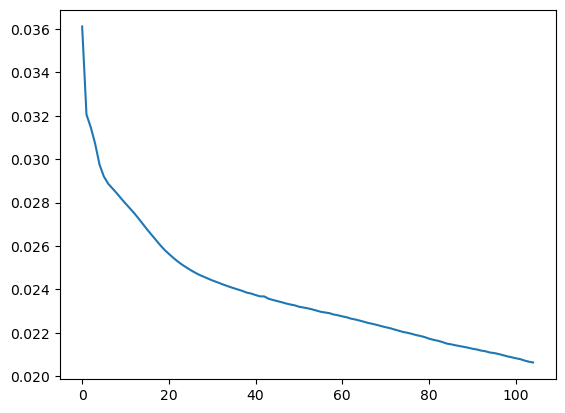

In [108]:
# training
nepochs = 150
Esave = []
model1 = model1.to(device)
loss = torch.nn.CrossEntropyLoss()
for e in range(nepochs):
        
    Esum = 0.0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        
        # forward
        out = model1(x)
        
        # loss
        E = loss(out,l.squeeze())
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(dataset_train))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()

In [114]:
# save model to disk
torch.save(model1.state_dict(), 'problem2_model1.pt')

In [29]:
model1.load_state_dict(torch.load('problem2_model1.pt'))

<All keys matched successfully>

In [15]:
# accuracy on training set
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model1(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracytrain1 = correct/count
print(f'Model 1 accuracy on the training set is {accuracytrain1}')

Model 1 accuracy on the training set is 0.7389753104038819


In [30]:
# validation set
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_val:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model1(x)
        c = torch.argmax(out,-1) # need to check this is the right size

        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracyval1 = correct/count
print(f'Model 1 accuracy on the validation set is {accuracyval1}')

# test set
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_test:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model1(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy1 = correct/count
print(f'Model 1 accuracy on the test set is {accuracy1}')

Model 1 accuracy on the validation set is 0.7178464606181456
Model 1 accuracy on the test set is 0.7137157107231921


In [16]:
# for CNN 2, first we will randomize the dataset
dataset_randomized = RandomizedDataset(
    dataset_train,
    random_rotate=True,
                 random_reflect=True, 
                 random_affine=True,
                 random_deformation=True,
                 random_window_level=True,
                 random_gamma=True,
                 random_noise=True,
)
dataloader_randomized = torch.utils.data.DataLoader(dataset_randomized,batch_size=8,num_workers=8)

In [17]:
# CNN 2, a wider model with batch normalization and data augmentation 
# CNN 2 is the model that is not a copy of the class examples - width, the type of data augmentation, regularization has been changed

class Model2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        channels0 = 10 #increased from 8 to 10
        kernel_size = 3
        stride = 2
        padding = 1
        
        self.c0 = torch.nn.Conv2d(3,channels0,kernel_size,1, padding)
        self.b0 = torch.nn.BatchNorm2d(channels0)
      
        self.c1 = torch.nn.Conv2d(channels0,channels0*2,kernel_size,stride, padding)
        self.b1 = torch.nn.BatchNorm2d(channels0*2)

        self.c2 = torch.nn.Conv2d(channels0*2,channels0*4,kernel_size,stride, padding)
        self.b2 = torch.nn.BatchNorm2d(channels0*4)
        
        self.c3 = torch.nn.Conv2d(channels0*4,channels0*8,kernel_size,stride, padding)
        self.b3 = torch.nn.BatchNorm2d(channels0*8)

        self.c4 = torch.nn.Conv2d(channels0*8, 8,kernel_size,stride, padding)
    
    
    def forward(self,x):
        # convolutions and nonlinearities
        x = self.c0(x)
        x = self.b0(x)
        x = torch.relu(x)        
        
        x = self.c1(x)
        x = self.b1(x)
        x = torch.relu(x)        

        x = self.c2(x)
        x = self.b2(x)
        x = torch.relu(x)

        x = self.c3(x)
        x = self.b3(x)
        x = torch.relu(x)
        
        x = self.c4(x)
        
        # average pool so we get one number
        
        x = torch.mean(x,(-1,-2))
        
        return x    

In [18]:
model2 = Model2()
model2= model2.to(device)

nparam = 0
for p in model2.parameters():
    nparam += p.numel()
print(f'{nparam} parameters')

44288 parameters


KeyboardInterrupt: 

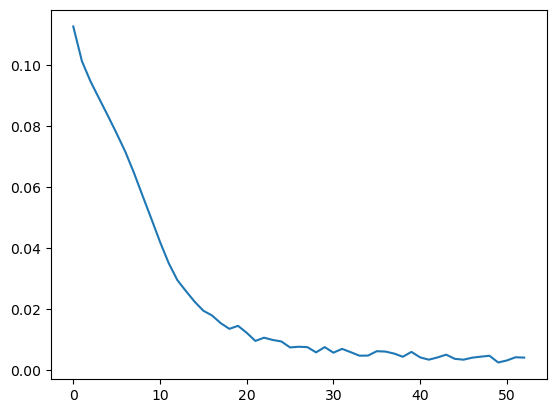

In [19]:
optimizer = torch.optim.Adam(model2.parameters(),lr=1e-3)

# training
nepochs = 100
Esave = []
model1 = model2.to(device)
loss = torch.nn.CrossEntropyLoss()
for e in range(nepochs):
        
    Esum = 0.0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        
        # forward
        out = model2(x)
        
        # loss
        E = loss(out,l.squeeze())
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(dataset_train))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()

In [20]:
torch.save(model2.state_dict(), 'problem2_model2.pt')

In [21]:
# accuracy on training set
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model2(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracytrain2 = correct/count
print(f'Model 2 accuracy on the training set is {accuracytrain2}')

# validation set
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_val:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model2(x)
        c = torch.argmax(out,-1) # need to check this is the right size

        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracyval2 = correct/count
print(f'Model 2 accuracy on the validation set is {accuracyval2}')

# test set
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_test:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model2(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy2 = correct/count
print(f'Model 2 accuracy on the test set is {accuracy2}')

Model 2 accuracy on the training set is 0.9937205651491365
Model 2 accuracy on the validation set is 0.707876370887338
Model 2 accuracy on the test set is 0.6822942643391521


In [32]:
print("Model 1 is the best performing model on the validation set and the accuracy on the test set is", accuracy1)

Model 1 is the best performing model on the validation set and the accuracy on the test set is 0.7137157107231921


## Part 3, image segmentation

For this problem we will use the lung segmentation dataset already shared in class.

In [33]:
x = np.load('images_x.npy')
y = np.load('segmentations_y.npy')

In [34]:
class LungDataset(torch.utils.data.Dataset):
    def __init__(self,split='train'):
        if split not in ['train','test','val']:
            raise Exception(f'split must be train test or val, but you input {split}')
        self.split = split
        if split == 'train':
            self.x = x[:-20].reshape((-1,1,64,64,))
            self.y = y[:-20].reshape((-1,1,64,64,))
        elif split == 'test':
            self.x = x[-10:].reshape((-1,1,64,64,))
            self.y = y[-10:].reshape((-1,1,64,64,))
        elif split == 'val':
            self.x = x[-20:-10].reshape((-1,1,64,64,))
            self.y = y[-20:-10].reshape((-1,1,64,64,))
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,i):
        return torch.tensor(self.x[i],dtype=torch.float32),torch.tensor( np.concatenate((self.y[i],1.0-self.y[i]))  , dtype=torch.float32)

In [35]:
dataset_lung_train = LungDataset(split='train')
I,l = dataset_lung_train[0]

In [36]:
dataset_lung_train_randomized = RandomizedDataset(
    dataset_lung_train,
    random_deformation=True,
    random_affine=True,
    random_gamma=True,
    random_window_level=False,
    random_noise=True,
)

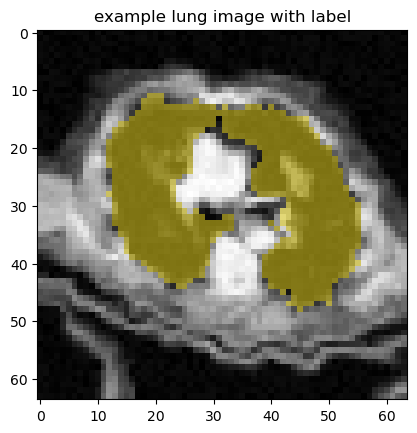

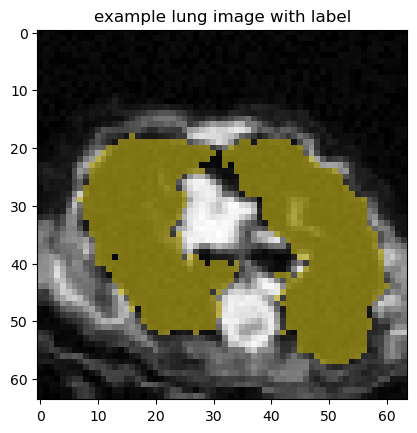

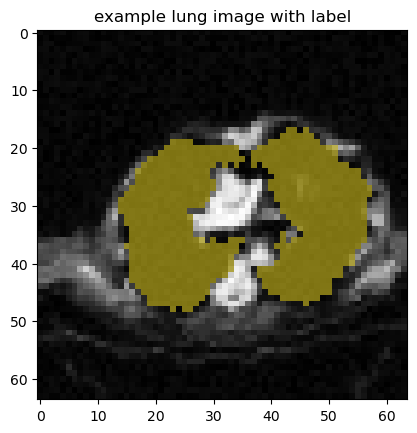

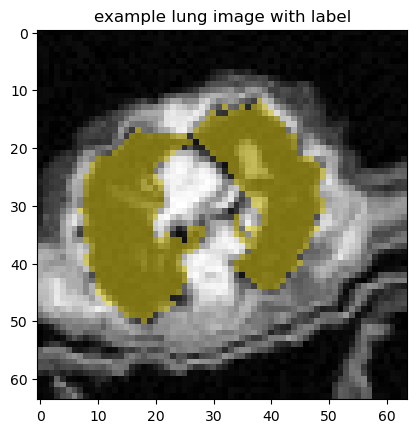

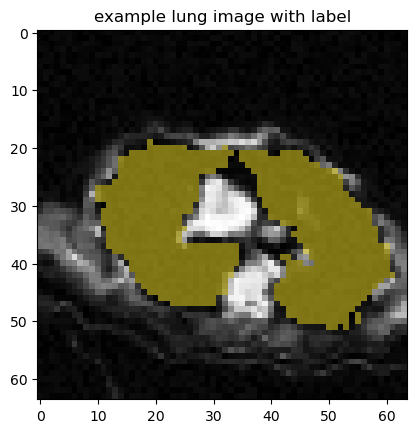

In [37]:
for i in range(5):
    I,l = dataset_lung_train_randomized[0]
    fig,ax = plt.subplots()
    ax.imshow(I[0],cmap='gray')
    ax.imshow(l[0],alpha=l[0]*0.5)
    ax.set_title('example lung image with label')

### Problem 3.1
Design at least two CNNs for segmenting the lung segmentation dataset.

You can choose any design you want, but at least one of the models should not be a copy of what we showed in class.

You may choose to vary the depth or width of the network, the type of data augmentation, any regularization, the loss function, the optimizer, etc.

You may (or may not) wish to make a new version of your randomization class, where you chose different parameters to generate realistic datasets.

In this dataset, flips and 90 degree rotations may (or may not) be useful, since all the images are already in a standard pose. You can investigate this in one of your training strategies if you want.

Train them on the training set (for however long you want), and test their Dice score and Hausdorff distance on the validation set.

Choose the best performing model on the validation set (using whatever criteria you'd like), and report its Haussdorf distance and Dice score on the test set.

I will rerun your notebook, and evaluate perforance in terms of Dice and Hausdorff on a random subset of the test set.  The random subset will be the same for all students.  2.5% of your grade (out of 100%) on this assignment will be based on your Dice score relative to the other students.  The student with the highest Dice will recieve 2.5%. The student with the lowest Dice will recieve 0%.  The others will vary linearly between these extremes.  

Another 2.5% of your grade (out of 100%) on this assignment will be based on your Hausdorff distance relative to the other students.  The student with the lowest distance will recieve 2.5%. The student with the highest distance will recieve 0%.  The others will vary linearly between these extremes.  

In [38]:
dataset_lung_train_randomized2 = RandomizedDataset(
    dataset_lung_train,
    random_deformation=False,
    random_affine=True,
    random_gamma=True,
    random_window_level=False,
    random_noise=True,
)
dataloader_lung = torch.utils.data.DataLoader(dataset_lung_train_randomized2,batch_size=8,shuffle=True)

In [39]:
# CNN 1, U-net (example from class)
class Model3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.chin = 1
        self.chout = 2
        self.ch0 = 8
        self.stride = 2
        self.pad = 1
        self.ksize = 3
        
        # downsampling
        self.c0 = torch.nn.Conv2d(self.chin,self.ch0,self.ksize,1,self.pad)
        self.c1 = torch.nn.Conv2d(self.ch0,self.ch0*2,self.ksize,self.stride,self.pad)
        self.c2 = torch.nn.Conv2d(self.ch0*2,self.ch0*4,self.ksize,self.stride,self.pad)
        self.c3 = torch.nn.Conv2d(self.ch0*4,self.ch0*8,self.ksize,self.stride,self.pad)                
        
        # upsampling
        self.ct3 = torch.nn.ConvTranspose2d(self.ch0*8,self.ch0*4,self.ksize,self.stride,self.pad,1)        
        self.ct2 = torch.nn.ConvTranspose2d(self.ch0*4*2,self.ch0*2,self.ksize,self.stride,self.pad,1)
        self.ct1 = torch.nn.ConvTranspose2d(self.ch0*2*2,self.ch0*1,self.ksize,self.stride,self.pad,1)
        self.ct0 = torch.nn.ConvTranspose2d(self.ch0*1*2,self.chout,self.ksize,1,self.pad)
    
    def forward(self,x):
        # downsampling
        stack = []
        x = torch.relu(self.c0(x))
        stack.append(x)
        
        x = torch.relu(self.c1(x))
        stack.append(x)
        
        x = torch.relu(self.c2(x))
        stack.append(x)
        
        x = torch.relu(self.c3(x))
        
        
        # upsampling
        x = torch.relu(self.ct3(x))
        
        x = torch.concatenate((x,stack.pop()),-3)        
        x = torch.relu(self.ct2(x))
        
        x = torch.concatenate((x,stack.pop()),-3)
        x = torch.relu(self.ct1(x))        
        
        x = torch.concatenate((x,stack.pop()),-3)
        x = self.ct0(x)
        return x

In [40]:
model3 = Model3()
optimizer = torch.optim.Adam(model3.parameters(),lr=1e-3)
loss = torch.nn.CrossEntropyLoss()

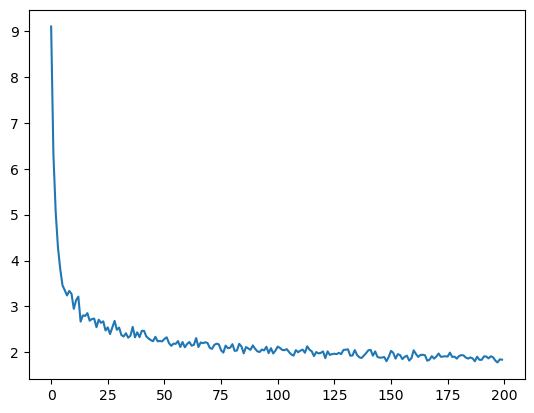

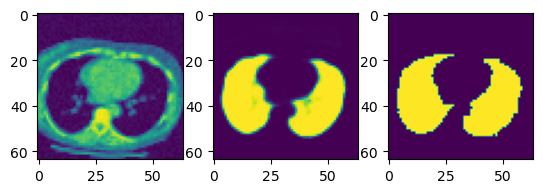

In [99]:
fig,ax = plt.subplots()
figI,axI = plt.subplots(1,3)
Esave = []
nepochs = 200
for e in range(nepochs):
    Esum = 0.0
    for x,l in dataloader_lung:
        optimizer.zero_grad()
        
        lhat = model3(x)
        E = loss(lhat,l)
        E.backward()
        
        optimizer.step()
        
        Esum += E.item()
    
    Esave.append(Esum)
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()
    
    with torch.no_grad():
        axI[0].cla()
        axI[0].imshow(x[0,0].cpu())
        
        axI[1].cla()
        axI[1].imshow(torch.softmax(lhat[0],0)[0].cpu(),vmin=0,vmax=1)
        
        axI[2].cla()
        axI[2].imshow(l[0,0].cpu(),vmin=0,vmax=1)
        
        figI.canvas.draw()

In [85]:
torch.save(model3.state_dict(), 'unet.pt')

In [41]:
model3.load_state_dict(torch.load('unet.pt'))

<All keys matched successfully>

In [42]:
dataset_lung_test = LungDataset(split='test')
dataloader_lung_test = torch.utils.data.DataLoader(dataset_lung_test,batch_size=8)

dataset_lung_val = LungDataset(split='val')
dataloader_lung_val = torch.utils.data.DataLoader(dataset_lung_val,batch_size=8)

In [43]:
def get_boundary(lhat_):
    # if it is a tensor, convert it to a numpy array
    if isinstance(lhat_,torch.Tensor):
        lhat_ = lhat_.clone().detach().cpu().numpy()
    
    # get boundary pixels by checking that a pixel value is not equal to its neighbor
    bhat = (lhat_[:,0] != np.roll(lhat_[:,0],shift=1,axis=-1)) 
    bhat = bhat +  (lhat_[:,0] != np.roll(lhat_[:,0],shift=-1,axis=-1)) 
    bhat = bhat +  (lhat_[:,0] != np.roll(lhat_[:,0],shift=1,axis=-2)) 
    bhat = bhat +  (lhat_[:,0] != np.roll(lhat_[:,0],shift=-1,axis=-2)) 
    bhat = bhat >= 1
    # make sure we only include the "inside" boundary, and not the "outside"
    bhat = (bhat * lhat_[:,0]) >= 1
    
        
    return bhat

def hausdorff(l,lhat_,show=False):    
    # get the boundary pixels
    bhat = get_boundary(lhat_)
    b = get_boundary(l)
    if show:
        fig,ax = plt.subplots(1,2)
        ax[0].imshow(lhat_[-1,0]*1.0 - l[-1,0]*1.0)
        ax[1].imshow(bhat[-1]*1.0 - b[-1]*1.0)
    # get the pixel locations
    x0 = np.arange(b.shape[-2])
    x1 = np.arange(b.shape[-1])    
    X = np.stack(np.meshgrid(x0,x1,indexing='ij'),-1)
    
    # loop over a minibatch
    h = []
    for i in range(l.shape[0]):
        x = X[b[i]]
        xhat = X[bhat[i]]
        # get pairwize distances in a 2D matrix, using "fancy indexing"
        d2 = np.sum( (x[:,None] - xhat[None,:])**2 , -1)
        # find the minima over each axis.  This gives the "closest pixel"
        d2m0 = np.min(d2,0)
        d2m1 = np.min(d2,1)
        # take the maximum over all these minimums
        d2m = np.concatenate((d2m0,d2m1))
        d2M = np.max(d2m)
        # append it into our minibatch
        h.append(np.sqrt(d2M))       
    return h

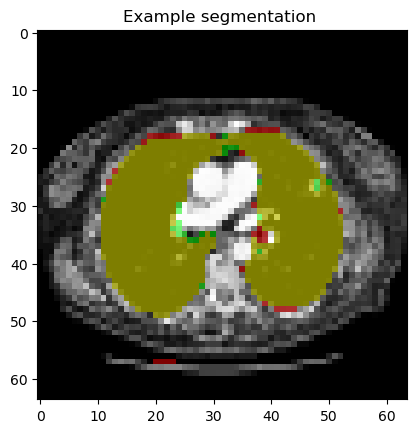

In [44]:
# compute our metrics here
dice_deep3 = []
iou_deep3 = []
h_deep3 = []
fig,ax = plt.subplots()
with torch.no_grad():
    for x,l in dataloader_lung_val:
        # get the prediction
        lhat = torch.softmax(model3(x) , 1)
        
        # binarize it
        lhat_ = lhat>0.5
        
        # we can use "times" to compute the intersection
        intersection = torch.sum(lhat_[:,0]*l[:,0],dim=(-1,-2))
        # we can use "plus" to compute the union
        union = torch.sum( (lhat_[:,0]+l[:,0])>=1  , dim=(-1,-2))
        # find the average volume for dice score
        avg = (torch.sum(lhat_[:,0],dim=(-1,-2))  + torch.sum(l[:,0],dim=(-1,-2)) )/2
        
        # distance betwen boundaries
        h_deep3.extend(hausdorff(l,lhat_))
        
        # dice score
        dice_deep3.extend(intersection/avg)
        # iou
        iou_deep3.extend(intersection/union)
        
    ax.imshow(x[-1,0],cmap='gray')
    ax.imshow(torch.stack( (lhat_[-1,0], l[-1,0], l[-1,0]*0, ( (lhat_[-1,0]+l[-1,0])>=1)*1.0*0.5  ), -1 ) )
    ax.set_title('Example segmentation ') 

In [45]:
print("Model 3 dice score (validation): ", torch.mean(torch.stack(dice_deep3)))
print("Model 3 Hausdorff distance (validation): ", np.mean(np.stack(h_deep3)))

Model 3 dice score (validation):  tensor(0.9117)
Model 3 Hausdorff distance (validation):  7.348289841021055


In [46]:
# CNN 2, U-net with batch normalization

class Model4(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.chin = 1
        self.chout = 2
        self.ch0 = 8
        self.stride = 2
        self.pad = 1
        self.ksize = 3
        
        # downsampling
        self.c0 = torch.nn.Conv2d(self.chin,self.ch0,self.ksize,1,self.pad)
        self.b0 = torch.nn.BatchNorm2d(self.ch0)
        
        self.c1 = torch.nn.Conv2d(self.ch0,self.ch0*2,self.ksize,self.stride,self.pad)
        self.b1 = torch.nn.BatchNorm2d(self.ch0*2)
       
        self.c2 = torch.nn.Conv2d(self.ch0*2,self.ch0*4,self.ksize,self.stride,self.pad)
        self.b2 = torch.nn.BatchNorm2d(self.ch0*4)
       
        self.c3 = torch.nn.Conv2d(self.ch0*4,self.ch0*8,self.ksize,self.stride,self.pad)  
        
        # upsampling
        self.ct3 = torch.nn.ConvTranspose2d(self.ch0*8,self.ch0*4,self.ksize,self.stride,self.pad,1)   
        self.bt3 = torch.nn.BatchNorm2d(self.ch0*4)
        
        self.ct2 = torch.nn.ConvTranspose2d(self.ch0*4*2,self.ch0*2,self.ksize,self.stride,self.pad,1)
        self.bt2 = torch.nn.BatchNorm2d(self.ch0*2)
        
        self.ct1 = torch.nn.ConvTranspose2d(self.ch0*2*2,self.ch0*1,self.ksize,self.stride,self.pad,1)
        self.bt1 = torch.nn.BatchNorm2d(self.ch0)
        
        self.ct0 = torch.nn.ConvTranspose2d(self.ch0*1*2,self.chout,self.ksize,1,self.pad)
    
    def forward(self,x):
        # downsampling
        stack = []
        x = self.c0(x)
        x = self.b0(x)
        x = torch.relu(x)
        stack.append(x)

        x = self.c1(x)
        x = self.b1(x)
        x = torch.relu(x)
        stack.append(x)

        x = self.c2(x)
        x = self.b2(x)
        x = torch.relu(x)
        stack.append(x)
        
        x = torch.relu(self.c3(x))

        # upsampling
        x = self.ct3(x)
        x = self.bt3(x)
        x = torch.relu(x)
        x = torch.concatenate((x,stack.pop()),-3)        

        x = self.ct2(x)
        x = self.bt2(x)
        x = torch.relu(x)
        x = torch.concatenate((x,stack.pop()),-3)

        x = self.ct1(x)
        x = self.bt1(x)
        x = torch.relu(x)      
        x = torch.concatenate((x,stack.pop()),-3)
        
        x = self.ct0(x)
        return x
        

In [47]:
model4 = Model4()
optimizer = torch.optim.Adam(model4.parameters(),lr=1e-3)
loss = torch.nn.CrossEntropyLoss()

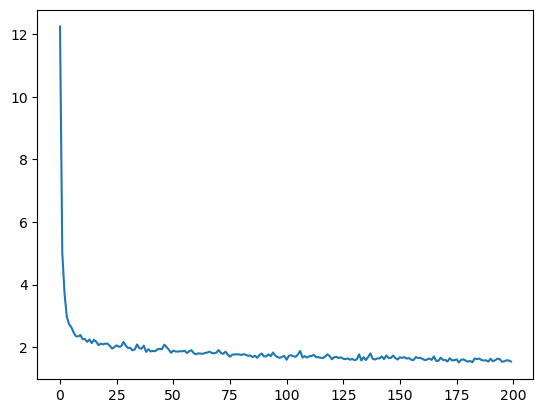

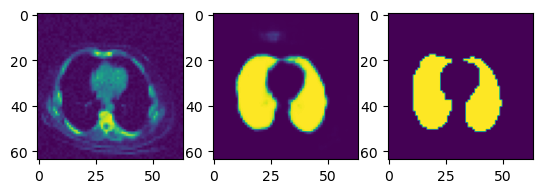

In [48]:
fig,ax = plt.subplots()
figI,axI = plt.subplots(1,3)
Esave = []
nepochs = 200
for e in range(nepochs):
    Esum = 0.0
    for x,l in dataloader_lung:
        optimizer.zero_grad()
        
        lhat = model4(x)
        E = loss(lhat,l)
        E.backward()
        
        optimizer.step()
        
        Esum += E.item()
    
    Esave.append(Esum)
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()
    
    with torch.no_grad():
        axI[0].cla()
        axI[0].imshow(x[0,0].cpu())
        
        axI[1].cla()
        axI[1].imshow(torch.softmax(lhat[0],0)[0].cpu(),vmin=0,vmax=1)
        
        axI[2].cla()
        axI[2].imshow(l[0,0].cpu(),vmin=0,vmax=1)
        
        figI.canvas.draw()

In [49]:
torch.save(model4.state_dict(), 'unet_bn.pt')

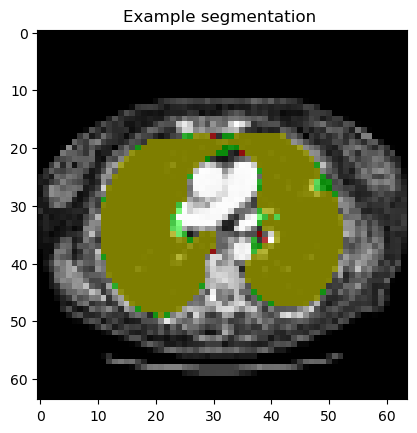

In [50]:
# compute our metrics here
dice_deep4 = []
iou_deep4 = []
h_deep4 = []
fig,ax = plt.subplots()
with torch.no_grad():
    for x,l in dataloader_lung_val:
        # get the prediction
        lhat = torch.softmax(model4(x) , 1)
        
        # binarize it
        lhat_ = lhat>0.5
        
        # we can use "times" to compute the intersection
        intersection = torch.sum(lhat_[:,0]*l[:,0],dim=(-1,-2))
        # we can use "plus" to compute the union
        union = torch.sum( (lhat_[:,0]+l[:,0])>=1  , dim=(-1,-2))
        # find the average volume for dice score
        avg = (torch.sum(lhat_[:,0],dim=(-1,-2))  + torch.sum(l[:,0],dim=(-1,-2)) )/2
        
        # distance betwen boundaries
        h_deep4.extend(hausdorff(l,lhat_))
        
        # dice score
        dice_deep4.extend(intersection/avg)
        # iou
        iou_deep4.extend(intersection/union)
        
    ax.imshow(x[-1,0],cmap='gray')
    ax.imshow(torch.stack( (lhat_[-1,0], l[-1,0], l[-1,0]*0, ( (lhat_[-1,0]+l[-1,0])>=1)*1.0*0.5  ), -1 ) )
    ax.set_title('Example segmentation ') 

In [51]:
print("Model 4 dice score (validation): ", torch.mean(torch.stack(dice_deep4)))
print("Model 4 Hausdorff distance (validation): ", np.mean(np.stack(h_deep4)))

Model 4 dice score (validation):  tensor(0.9278)
Model 4 Hausdorff distance (validation):  5.381069033999705


Model 4 is the best performing model on the validation test out of the two models
Model 4 dice score (test):  tensor(0.9705)
Model 4 Hausdorff distance (test):  2.5793152003327635


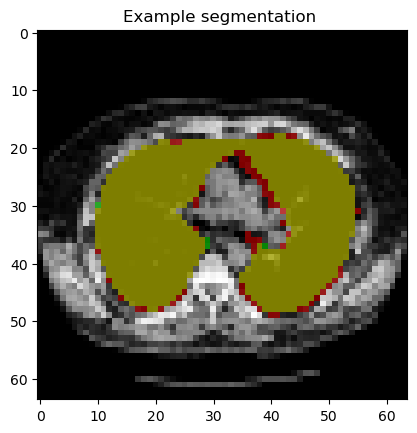

In [52]:
# computing metrics for model 4 on the test set
dice_test = []
iou_test = []
h_test = []
fig,ax = plt.subplots()
with torch.no_grad():
    for x,l in dataloader_lung_test:
        # get the prediction
        lhat = torch.softmax(model4(x) , 1)
        
        # binarize it
        lhat_ = lhat>0.5
        
        # we can use "times" to compute the intersection
        intersection = torch.sum(lhat_[:,0]*l[:,0],dim=(-1,-2))
        # we can use "plus" to compute the union
        union = torch.sum( (lhat_[:,0]+l[:,0])>=1  , dim=(-1,-2))
        # find the average volume for dice score
        avg = (torch.sum(lhat_[:,0],dim=(-1,-2))  + torch.sum(l[:,0],dim=(-1,-2)) )/2
        
        # distance betwen boundaries
        h_test.extend(hausdorff(l,lhat_))
        
        # dice score
        dice_test.extend(intersection/avg)
        # iou
        iou_test.extend(intersection/union)
        
    ax.imshow(x[-1,0],cmap='gray')
    ax.imshow(torch.stack( (lhat_[-1,0], l[-1,0], l[-1,0]*0, ( (lhat_[-1,0]+l[-1,0])>=1)*1.0*0.5  ), -1 ) )
    ax.set_title('Example segmentation ') 

print("Model 4 is the best performing model on the validation test out of the two models")
print("Model 4 dice score (test): ", torch.mean(torch.stack(dice_test)))
print("Model 4 Hausdorff distance (test): ", np.mean(np.stack(h_test)))


## Part 4, the MEDMNIST paper

Read the paper, MedMNIST v2 - A large-scale lightweight benchmark for 2D and 3D biomedical image classification, shared on the course website.


### Problem 4.1

Why was this family of datasets developed?

Answer: This family of datasets was developed for educational and research purposes (ie. machine learning, computer vision, etc within the biomedical field) and addresses the scarcity of 3D classification datasets. Also, the diverseness and standardization of these datasets are helpful when evaluating performance of machine learning algorithms.

### Problem 4.2

For the DermaMNIST dataset, describe the medical problem that machine learning techniques could be used to solve or automate.

Answer: Using the DermaMNIST dataset, machine learning techniques can be used to classify images of skin lesions into 7 different diseases. That is, it could produce a diagnosis based on an image.


## Part 5, The Unet-Paper

Read the paper, U-Net: Convolutional Networks for Biomedical Image Segmentation, shared on the course website.

### Problem 5.1

What task was the unet developed to solve?

Answer: U-net was developed to work with very few training images while also resulting in more precise image segmentation. It also addressed the issue of efficiency/long training times. 

### Problem 5.2
Describe 2 ways in which the model architecture presented in this paper differed from the basic unet model we discussed in class (note you can find more than two differences).

Answer:
1. At each step/"level", convolution + ReLU is applied twice before downsampling rather than once as shown in the class example
2. The paper network model has 23 convolutional layers, while the class example has 8.

### Problem 5.3
Describe how the cross entropy loss function presented in the paper different from the one defined in class?

Answer:
The paper's cross entropy loss function differs in that it uses a weight map to balance the class frequencies. 